## <center>Concepts of Data Science - Group Project</center>
### <center>Implementation and Benchmarking of a Bloom Filter</center>
#### <center>Karina Bule-Flori, Matteo Ramina</center>

### 1 Introduction

In this Jupyter notebook, we integrate both object-oriented and procedural programming techniques to implement, benchmark, and test a Bloom filter (*BloomFilter2* of *bloomf.py*). As outlined by Tarkoma, Rothenberg, and Lagerspetz (2011), a Bloom filter is a space-efficient probabilistic data structure that may produce false positives (incorrectly indicating that an element is in the set when it is not) but never false negatives (failing to identify an element that is in the set). Essentially, a Bloom filter is an array of $m$ bits representing a set $S = {x_1, x_2, ..., x_n}$ of $n$ elements, which are initialized as zero. The underlying concept is to map items $x \in S$ to random numbers uniformly distributed in the range $1, ..., m$ using $k$ hash functions, denoted as $h_i(x), 1 \leq i \leq k$.

Our Bloom filter takes as inputs $n$, the size of the set $S$, and the desired false positive probability $p \in [0, 1]$. In turn, the size of the bit array is computed as:
$$m = - \frac{n ln(p)}{[ln(2)]^2}$$

While the number of hash functions is determined by:
$$k = \frac{m}{n}ln(2)$$

We will benchmark and test the Bloom filter through simulations. Specifically, the Bloom filter is designed to store file names generated by the auxiliary function *generate_random_strings*, which creates random strings representing file names that can range from 1 to 255 characters. This upper limit was chosen because it is the maximum file name length in Windows and macOS. We will simulate the creation of names and evaluate the Bloom filter’s characteristics, such as the false positive rate, insertion time, and query time, using these simulated names.

Reference: Tarkoma, S., Rothenberg, C. E., & Lagerspetz, E. (2011). Theory and practice of bloom filters for distributed systems. *IEEE Communications Surveys & Tutorials, 14*(1), 131-155.

### 2 Implementation

The bloom filter has been implemented with the following characteristics:

- It calculates $m$ and $k$ dynamically based on the number of items expected and the desired false positive probability.

- It includes an *add* function to insert items in the bloom filter, as well as a *check* function to look up values stored in the bloom filter.

- It allows to retrieve information regarding the bloom filter such as the size of the bit array via the function *generate_stats*.

- It can clear the content of the bloom filter through the function *clear*, which is particularly important for simulation purposes.

```python

class BloomFilter2:
    """
    Class for Bloom filter using Murmur3 hash function.

    Attributes:
    - n (int): Number of items expected to be stored in Bloom filter.
    - p (float): Desired false positive rate.

    Methods:
    - __init__(n, p): Initializes the Bloom filter with parameters n and p.
    - add(item): Inserts an element into the Bloom filter.
    - check(item): Checks if an element exists in the Bloom filter.
    - length(): Returns the current size of the Bloom filter.
    - generateStats(): Calculates and prints statistics of the Bloom filter.
    - clear(): Reinitializes the Bloom filter and clears old values and statistics.
    """

    def __init__(self, n, p):
        """
        Initialize BloomFilter2 with parameters n and p.

        Args:
        - n (int): Number of items expected to be stored in Bloom filter.
        - p (float): Desired false positive rate.
        """

        self.n = n
        self.p = p

        self.m = math.ceil(-n * math.log(p) / (math.log(2) ** 2))
        self.k = math.ceil((self.m / n) * math.log(2))

        self.bit_array = bitarray(self.m)
        self.bit_array.setall(0)

    def _hashes(self, item):
        """
        Generate k hash values for the given item.

        Args:
        - item: Element to hash.

        Returns:
        - List of k hash values.
        """

        return [mmh3.hash(item, i) % self.m for i in range(self.k)]

    def add(self, item):
        """
        Insert an element into the Bloom filter.

        Args:
        - item: Element to insert.
        """

        for hash_val in self._hashes(item):
            self.bit_array[hash_val] = 1

    def check(self, item):
        """
        Check if an element exists in the Bloom filter.

        Args:
        - item: Element to check.

        Returns:
        - bool: True if the element is likely present; otherwise, False.
        """

        return all(self.bit_array[hash_val] for hash_val in self._hashes(item))

    def length(self):
        """
        Return the current size of the Bloom filter.

        Returns:
        - int: Current size of the Bloom filter.
        """

        return self.n

    def generateStats(self):
        """
        Calculate and print statistics of the Bloom filter.

        Statistics include:
        - Predicted false positive rate.
        - Number of elements entered in filter.
        - Number of bits in filter.
        - Number of hashes in filter.
        """

        n = float(self.n)
        m = float(self.m)
        k = float(self.k)
        p_fp = (1 - math.exp(-k * n / m)) ** k
        print("Predicted false positive rate: ", p_fp * 100.0)
        print("Number of elements entered in filter: ", n)
        print("Number of bits in filter: ", m)
        print("Number of hashes in filter: ", k)

    def clear(self):
        """
        Reinitialize the Bloom filter and clear old values and statistics.
        """

        self.bit_array.setall(0)

```

### 3 Benchmarking

#### 3.1 Performance

To benchmark our Bloom filter's performance in maintaining a 5% false positive prediction rate, we conducted a series of simulations. The function *test_performance* evaluates the Bloom filter by using a provided list of file names, which is randomly divided into names that will be added into the filter and names that will not. The Bloom filter is then tested to determine its false positive rate.

Each simulation begins by clearing the Bloom filter and shuffling the name list. A subset of the file names is added into the filter, while the remaining names are used to test for false positives by looking them up. By repeating this process 100 times (as specified by *sim_num*) for each sample size, we gather an average false positive rate across simulations. This average provides an empirical measure of the filter's performance relative to the target false positive rate of 5%.

To visually represent the results, we employed the *generate_graph* function.

Two benchmarking scenarios were considered: one with a fixed Bloom filter size and another with a dynamically adjusting filter size based on the input set size.

```python

def test_performance(bloom_filter: BloomFilter2, probability: float, names_list: List[str], sim_num: int) -> float:
    """
    Evaluate the performance of a Bloom filter in maintaining a specified false positive rate.

    Parameters:
    - bloom_filter (BloomFilter2): An instance of the BloomFilter2 class to be tested.
    - probability (float): Desired false positive probability (e.g., 0.05 for 5%).
    - names_list (List[str]): List of names used to test the Bloom filter.
    - sim_num (int): Number of simulations to run for averaging results.

    Returns:
    - float: Average false positive rate observed across simulations.

    The function evaluates the Bloom filter's ability to achieve and maintain a false positive rate
    close to the specified probability. It clears the Bloom filter, inserts a subset of names_list
    items (based on the given probability), and then checks the filter's response to items not
    inserted. This process is repeated across multiple simulations to calculate an average false
    positive rate.
    """

    false_positive_rate = []

    for _ in range(sim_num):

        bloom_filter.clear()
        shuffle(names_list)
        num_names_present = int((1 - probability) * len(names_list))
        names_present = names_list[:num_names_present]
        names_absent = names_list[num_names_present:]

        for element in names_present:
            bloom_filter.add(element)

        false_positives = 0

        for name in names_absent:
            if bloom_filter.check(name):
                false_positives += 1

        false_positive_rate.append(false_positives / len(names_absent))

    false_positive_rate_average = sum(false_positive_rate)/len(false_positive_rate)
        
    return false_positive_rate_average

def generate_graph(data, name, title):
    """
    Generate a bar graph visualizing false positive rates against sample sizes.

    Parameters:
    - data (list of dicts): Data containing 'name_list_size' and 'false_positive_rate' entries.
    - name (str): File name to save the generated graph.
    - title (str): Title of the graph.

    Generates a bar graph with sample sizes on the x-axis and corresponding false positive rates
    on the y-axis. The function expects data in the format of a list of dictionaries where each
    dictionary contains 'name_list_size' (sample size) and 'false_positive_rate' (rate to be plotted)
    entries. The graph includes a horizontal dashed line at y=0.05 to indicate the target false
    positive rate of 5%. The graph is saved as a file named 'name' and displayed using matplotlib.
    """

    name_list_sizes = [entry['name_list_size'] for entry in data]
    false_positive_rates = [entry['false_positive_rate'] for entry in data]

    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.2
    index = range(len(data))
    ax.bar(index, false_positive_rates, width=bar_width, label='False Positive Rate')

    ax.set_xlabel('Sample Size')
    ax.set_ylabel('False Positive Rate')
    ax.set_title(title)
    ax.axhline(y=0.05, color='r', linestyle='--', linewidth=1, label='Target 5% FPR')
    ax.legend()
    xticks = [100, 5000, 10000, 15000, 20000, 25000, 30000]
    ax.set_xticks([name_list_sizes.index(x) for x in xticks])
    ax.set_xticklabels(xticks)

    plt.tight_layout()
    plt.savefig(name)
    plt.show()

if __name__ == "__main__":

    seed(1010)
    sim_num = 100

    # Parameters for Bloom filter and simulation
    n = 20000
    p = 0.05
    
    # Parameters for varying name lengths and list sizes
    name_min_char = 1
    name_max_char = 255
    name_list_min = 100
    name_list_max = 30000
    name_list_step = 100

    # Initialize list to store results and Bloom filter with fixed parameters
    results_fixed = []
    bloom_filter = BloomFilter2(n, p)

    # Test performance for different sizes of name lists with fixed Bloom filter
    for i in range(name_list_min, name_list_max + name_list_min, name_list_step):

        names_list = generate_random_strings(i, name_min_char, name_max_char)
        false_positive_rate = test_performance(bloom_filter, p, names_list, sim_num)
        results_fixed.append({'name_list_size': i, 'false_positive_rate': false_positive_rate})
    
    generate_graph(results_fixed, 'chart_1_fixed_bf.png', 'Chart 1. False positive rate for fixed Bloom filter')

    # Initialize list to store results for dynamically adjusted Bloom filter
    results_dynamic = []

    # Test performance for different sizes of name lists with dynamically adjusted Bloom filter
    for i in range(name_list_min, name_list_max + name_list_min, name_list_step):

        names_list = generate_random_strings(i, name_min_char, name_max_char)
        bloom_filter = BloomFilter2(i, p)
        false_positive_rate = test_performance(bloom_filter, p, names_list, sim_num)
        results_dynamic.append({'name_list_size': i, 'false_positive_rate': false_positive_rate})
    
    generate_graph(results_dynamic, 'chart_2_dynamic_bf.png', 'Chart 2. False positive rate for dynamically adjusted Bloom filter')
```

As shown in the graphs below, the Bloom filter's behavior varies depending on whether its parameters are fixed or dynamically adjusted.

The first graph illustrates the performance of a fixed Bloom filter initialized with an expected capacity of 20,000 items and a false positive probability of 0.05. It shows that for sample sizes well below the expected capacity, the Bloom filter maintains a false positive rate significantly below 5%. However, as the sample size approaches the expected capacity, the false positive rate increases. Around 21,000 items, the Bloom filter fails to maintain the 0.05 false positive probability, and the rate increases linearly thereafter.

In contrast, the second graph showcases the performance of a dynamically adjusted Bloom filter, where the expected capacity is determined by the size of the sampled items added to the filter during the simulation. This approach performs much better, maintaining a false positive rate of around 5% throughout the simulations, regardless of the sample size.

These results indicate the superiority of using a dynamically adjusted Bloom filter for ensuring a consistent false positive rate. Additionally, they suggest that the effective false positive probability may actually be slightly below 5%.

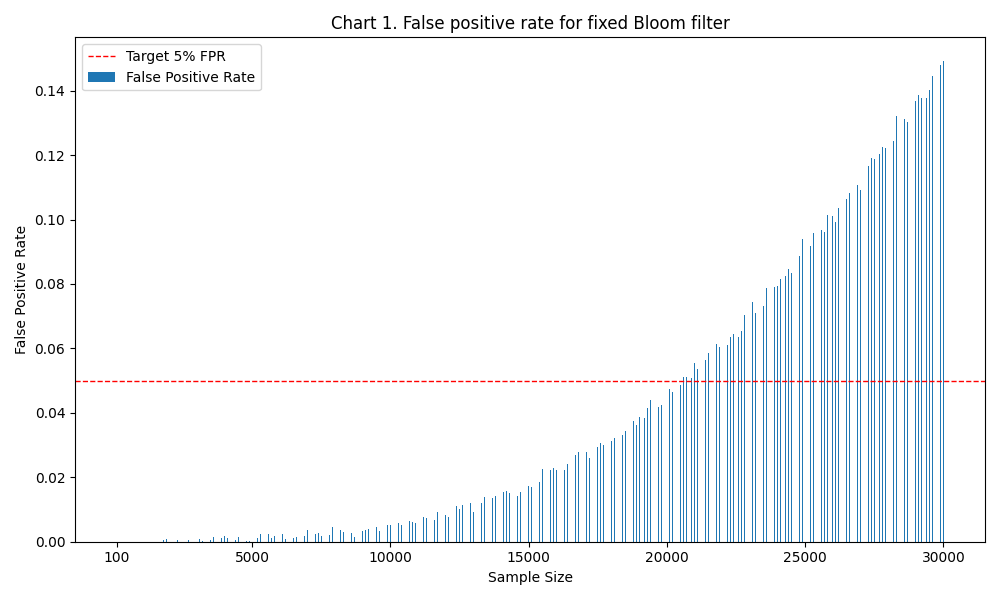

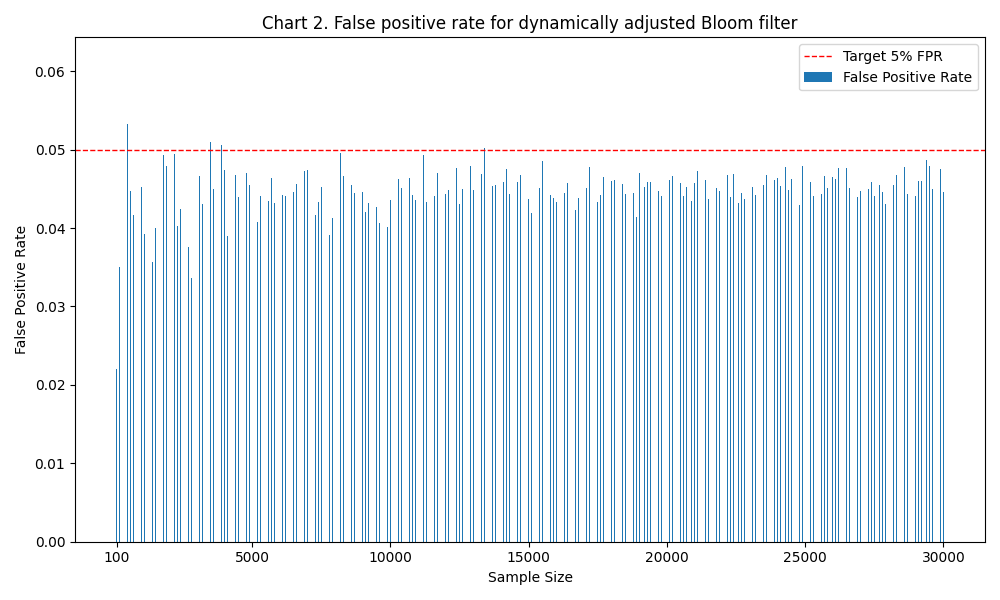

In [4]:
from IPython.display import Image, display

display(Image(filename='chart_1_fixed_bf.png'))
display(Image(filename='chart_2_dynamic_bf.png'))

#### 3.2 Theoretical Complexity

##### 3.2.1 Adding

The BloomFilter2 class utilizes hash functions to efficiently add and check for elements in the Bloom filter. When adding an element (*add* method), the algorithm computes hash values using $k$ hash functions, where $k$ is determined by the size of the filter relative to the expected number of elements $n$ and the desired false positive rate $p$. The time complexity for adding an element is:
$$O(k)$$

##### 3.2.2 Checking

Similar to the *add* method, when checking for the presence of an element (*check* method), the algorithm computes hash values using the same $k$ hash functions and checks if all corresponding bits in the bit array are set. This operation also has a time complexity of: $$O(k)$$

#### 3.3 Empirical Complexity

The empirical complexity of the adding and checking of the Bloom filter has been executed using the function below. More specifically, the function *test_add_check* evaluates the performance of the Bloom filter by measuring the time taken to add elements and check their membership across multiple simulations.

During each simulation, the function tracks the time taken to add each individual word (*item_add_time*) and the total time taken for all additions (*total_add_time*). For each word in the words_list, the *add* method of the Bloom filter is called, and the time taken is recorded. Subsequently, the function measures the time to check each individual word (*item_check_time*) and the total time for all checks (*total_check_time*). For each word in the words_list, the *check* method of the Bloom filter is executed, and the time taken is recorded.

After completing all simulations, the function computes the average time per element for both the *add* and *check* operations across all simulations. This is achieved by dividing the total time by the number of elements processed.

As in the false positive rate benchmarking, this is performed for both a fixed Bloom filter and a dynamically adjusted Bloom filter. However, only results for the fixed Bloom filter are reported.

```python

from bloomf import BloomFilter2
from generate_random_strings import generate_random_strings
from random import seed
from typing import List, Tuple
import time
import matplotlib.pyplot as plt

def test_add_check(bloom_filter: BloomFilter2, names_list: List[str], sim_num: int) -> Tuple[float, float, float, float]:
    """
    Test the performance of a Bloom filter in adding and checking elements.
    
    Parameters:
    - bloom_filter (BloomFilter2): The Bloom filter instance to test.
    - names_list (List[str]): List of names to add and check in the Bloom filter.
    - sim_num (int): Number of simulations to perform for averaging times.
    
    Returns:
    Tuple[float, float, float, float]: A tuple containing:
    - item_add_time_average (float): Average time taken to add each item (in milliseconds).
    - total_add_time_average (float): Average total time taken to add all items (in milliseconds).
    - item_check_time_average (float): Average time taken to check each item (in milliseconds).
    - total_check_time_average (float): Average total time taken to check all items (in milliseconds).
    """

    item_add_time = []
    total_add_time = []
    item_check_time = []
    total_check_time = []

    for _ in range(sim_num):

        start_add_time = time.time_ns()
        
        for item in names_list:
            start_add_time_elem = time.time_ns()
            bloom_filter.add(item)
            end_add_time_elem = time.time_ns()
            item_add_time.append(end_add_time_elem - start_add_time_elem)
        
        end_add_time = time.time_ns()
        total_add_time.append(end_add_time - start_add_time)

        start_check_time = time.time_ns()

        for item in names_list:
            start_check_time_elem = time.time_ns()
            bloom_filter.check(item)
            end_check_time_elem = time.time_ns()
            item_check_time.append(end_check_time_elem - start_check_time_elem)            
        
        end_check_time = time.time_ns()
        total_check_time.append(end_check_time - start_check_time)

    item_add_time_average = sum(item_add_time) / (sim_num * len(names_list))
    total_add_time_average = sum(total_add_time)/sim_num

    item_check_time_average = sum(item_check_time) / (sim_num * len(names_list))
    total_check_time_average = sum(total_check_time)/sim_num

    return item_add_time_average, total_add_time_average, item_check_time_average, total_check_time_average

def get_average_item_time(times):
    """
    Calculate the weighted average time per item for adding and checking operations.

    Parameters:
    - times (List[Dict[str, float]]): List of dictionaries containing times for different sample sizes.
      Each dictionary should have keys 'sample_size', 'item_add_time', and 'item_check_time'.

    Returns:
    Tuple[float, float]: A tuple containing:
    - item_add_time_average (float): Weighted average time per item for adding (in milliseconds).
    - item_check_time_average (float): Weighted average time per item for checking (in milliseconds).
    """

    item_add_time_weighted_average_num = 0
    item_add_time_weighted_average_denom = 0
    item_check_time_weighted_average_num = 0
    item_check_time_weighted_average_denom = 0

    for i, _ in enumerate(times):
        sample_size = times[i]["sample_size"]
        item_add_time = times[i]["item_add_time"]
        item_check_time = times[i]["item_check_time"]

        item_add_time_weighted_average_num += sample_size * item_add_time
        item_add_time_weighted_average_denom += sample_size
        item_check_time_weighted_average_num += sample_size * item_check_time
        item_check_time_weighted_average_denom += sample_size

    item_add_time_average = item_add_time_weighted_average_num / item_add_time_weighted_average_denom if item_add_time_weighted_average_denom != 0 else 0
    item_check_time_average = item_check_time_weighted_average_num / item_check_time_weighted_average_denom if item_check_time_weighted_average_denom != 0 else 0

    return item_add_time_average, item_check_time_average

if __name__ == "__main__":

    seed(1010)
    sim_num = 100

    # Parameters for Bloom filter and simulation
    n = 20000
    p = 0.05
    
    # Parameters for varying name lengths and list sizes
    name_min_char = 1
    name_max_char = 255
    name_list_min = 100
    name_list_max = 30000
    name_list_step = 100

    # Initialize list to store results and Bloom filter with fixed parameters
    results_fixed = []
    bloom_filter = BloomFilter2(n, p)

    # Test performance for different sizes of name lists with fixed Bloom filter
    for i in range(name_list_min, name_list_max + name_list_min, name_list_step):

        names_list = generate_random_strings(i, name_min_char, name_max_char)
        
        item_add_time_average, total_add_time_average, item_check_time_average, total_check_time_average = test_add_check(bloom_filter, names_list, sim_num)

        results_fixed.append({'sample_size': i, 'item_add_time': item_add_time_average / 1e6, 'total_add_time': total_add_time_average / 1e6,
                        'item_check_time': item_check_time_average / 1e6, 'total_check_time': total_check_time_average / 1e6})

    item_add_time_average_fixed, item_check_time_average_fixed = get_average_item_time(results_fixed)

    # Create plot
    sample_sizes = [entry['sample_size'] for entry in results_fixed]
    total_add_times = [entry['total_add_time'] for entry in results_fixed]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sample_sizes, total_add_times, marker='o', linestyle='-', color='b')
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Total Add Time in Milliseconds')
    ax.set_title('Chart 3. Sample Size vs Total Add Time for Fixed Bloom Filter')
    plt.tight_layout()
    plt.savefig('chart_3_fixed_add.png')
    plt.show()

    # Create plot
    sample_sizes = [entry['sample_size'] for entry in results_fixed]
    total_check_times = [entry['total_check_time'] for entry in results_fixed]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sample_sizes, total_check_times, marker='o', linestyle='-', color='b')
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Total Check Time in Milliseconds')
    ax.set_title('Chart 4. Sample Size vs Total Check Time for Fixed Bloom Filter')
    plt.tight_layout()
    plt.savefig('chart_4_fixed_check.png')
    plt.show()

    # Initialize list to store results for dynamically adjusted Bloom filter
    results_dynamic = []

    # Test performance for different sizes of name lists with dynamically adjusted Bloom filter
    for i in range(name_list_min, name_list_max + name_list_min, name_list_step):

        bloom_filter = BloomFilter2(i, p)

        names_list = generate_random_strings(i, name_min_char, name_max_char)
        
        item_add_time_average, total_add_time_average, item_check_time_average, total_check_time_average = test_add_check(bloom_filter, names_list, sim_num)

        results_dynamic.append({'sample_size': i, 'item_add_time': item_add_time_average / 1e6, 'total_add_time': total_add_time_average / 1e6,
                        'item_check_time': item_check_time_average / 1e6, 'total_check_time': total_check_time_average / 1e6})

        if i % 1000 == 0:
            print({'sample_size': i, 'item_add_time': total_check_time_average})

    item_add_time_average_dynamic, item_check_time_average_dynamic = get_average_item_time(results_dynamic)
```

The results below corroborate that the adding and checking algorithms have a linear complexity, as this increases linearly with the size of the Bloom filter's input.

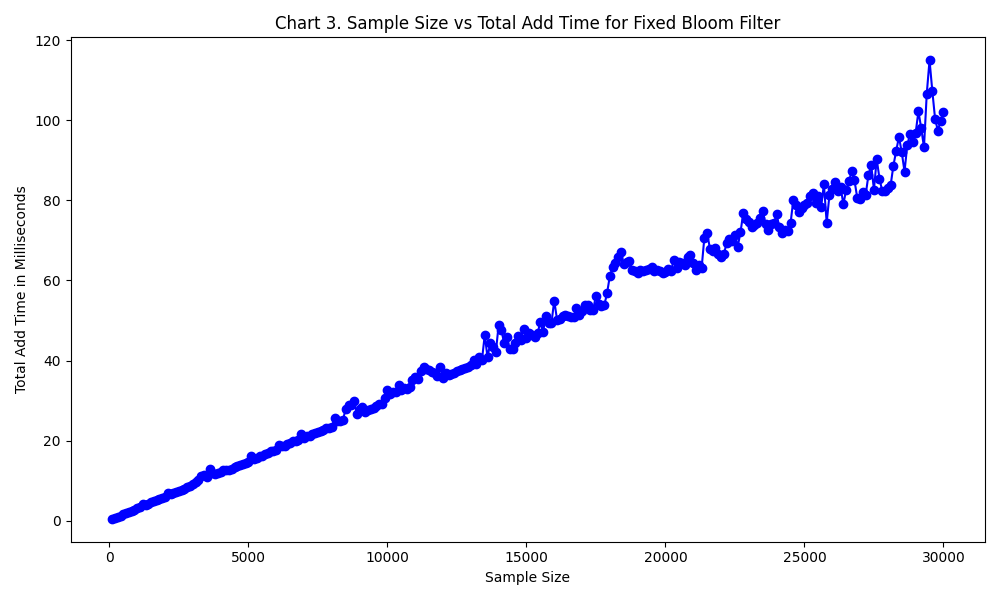

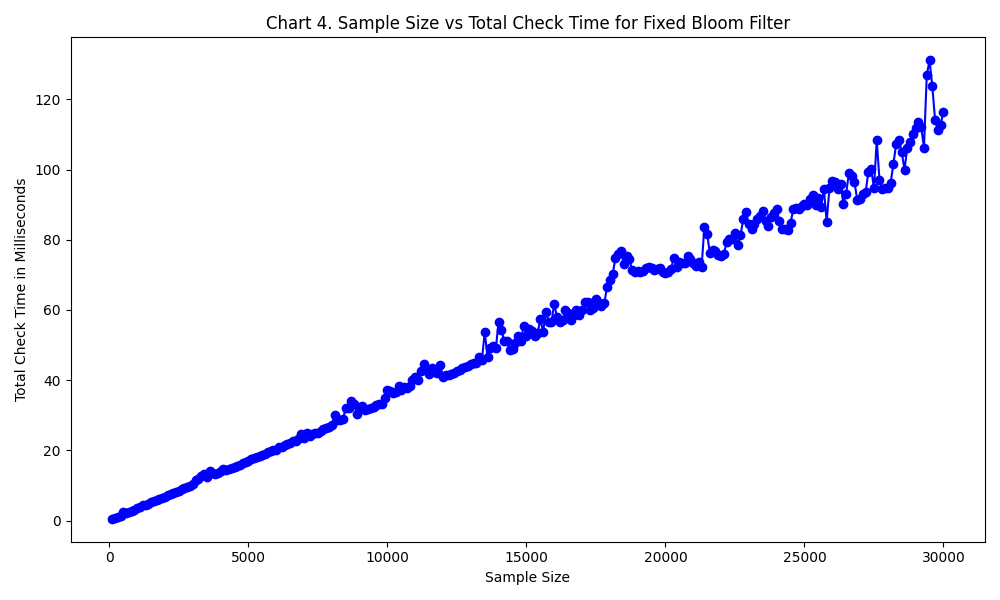

In [5]:
from IPython.display import Image, display

display(Image(filename='chart_3_fixed_add.png'))
display(Image(filename='chart_4_fixed_check.png'))


### 4 Limitations

The benchmarking and testing were conducted with a limited range of input sizes (up to 30,000) and a limited number of simulations (100). Consequently, the estimates could have been more precise. Greater precision could have been achieved by using the Vlaams Supercomputer Centrum (VSC). However, due to an "ERROR: sam-balance crashed," we were unable to utilize it.